# Radius-Guided Post-Clustering for Shape-Aware, Scalable Refinement of k-Means Results

## Table of contents
1. [Helper functions and imports](#helperfunctions)
2. [K-Means with Cluster Merging and Density Code](#kmeanscdcode)
3. [Main Concept](#mainconcept)
4. [FCPS (Fundamental Clustering Problem Suite)](#clearlyseparabledatasets)
5. [Test: Chameleon_t5_8k](#densityandoverlap)
6. [Splitting the Dataset: Toy Examples](#six)
7. [Splitting the dataset: FCPS](#seven)
8. [K-Means standalone](#eight) 

Please run 1 + 2 before anything else, or nothing will work

## 1. Helper functions and imports <a name="helperfunctions"></a>

### Imports

In [ ]:
# k-means
from sklearn.cluster import KMeans

# data set creators
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

# numpy
import numpy as np

# pyplot
from matplotlib import pyplot as plt

# distance matrix
from sklearn.metrics import pairwise_distances

# volume of n-ball
import math

# 3D plots
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [ ]:
import sklearn
print(sklearn.__version__) 
# used 1.6.1

1.6.1


In [ ]:
np.version.version
# used 1.23.5

'1.23.5'

In [ ]:
import matplotlib
matplotlib.__version__
# used 3.8.1

'3.8.1'

In [ ]:
sns.__version__
# used 0.13.2

'0.13.2'

### Helper functions for plotting

In [ ]:
def plot_clustering(X, labels, cluster_centers=None, radii=None, outliers=-1, only_circles=False, 
                    max_r = None, min_r=None):
    """
    Plots the clustering in color for 2 dimensional data sets.
    If cluster_centers_ and radius_matrix_ from a KMeansCD model are supplied, circles are drawn.
    Set only_circles=True to see only these circles.
    """
    plt.figure(figsize=(10,10))

    unique_labels = set(labels)
    
    colors = sns.color_palette("Spectral",  len(unique_labels))
    
    if only_circles == True:
        alpha=0
    else:
        alpha=1

    for label, color in zip(unique_labels, colors):
        if label == outliers:
            color = [0, 0, 0, 1]

        data = X[labels == label]
        plt.plot(data[:, 0], data[:, 1], 'o', markerfacecolor=color,
             markeredgecolor="black", markersize=8, alpha=alpha)       
    
    if cluster_centers is not None and radii is not None:
        for i in range(cluster_centers.shape[0]):
            if min_r is not None and max_r is not None:
                if radii[0,i] > min_r and radii[0,i] < max_r:
                    circle = plt.Circle(cluster_centers[i], radii[0, i], color='black', fill=False)
                    plt.gca().add_patch(circle)
            else:
                circle = plt.Circle(cluster_centers[i], radii[0, i], color='black', fill=False)
                plt.gca().add_patch(circle)
    
    plt.show()

In [ ]:
# 3D Plotting
def plot_clustering_3d(X, labels):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
        for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        xy = X[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', s=100, edgecolor='k')

    plt.show()

### helper functions for labels

In [ ]:
def unify_labels(labels1, labels2, labels1_outlier=-1, labels2_outlier=-1):
    
    """
    Unifies two labelings for the same data set
    """
    assert labels1.shape == labels2.shape, "Labels' shapes differ!"
    initial_num_labels2 = len(set(labels2))
    labels_unified = labels2.copy()
    if labels2_outlier != labels1_outlier: # switch outlier labels if needed
        labels_unified[np.where(labels2 == labels2_outlier)] = labels1_outlier 
    labels1_unique = np.array(list(set(labels1)))
    labels2_unique = np.array(list(set(labels2)))
    adjacency_matrix = np.zeros((labels1_unique.shape[0], labels2_unique.shape[0]))
    for i in range(labels1_unique.shape[0]):
        for j in range(labels2_unique.shape[0]):
            if labels1_unique[i] == labels1_outlier or labels2_unique[j] == labels2_outlier:
                adjacency_matrix[i,j] = 0 # outliers will not be synced by this mechanism
            else:
                indices_labels1 = set(np.where(labels1 == labels1_unique[i])[0])
                indices_labels2 = set(np.where(labels2 == labels2_unique[j])[0])
                len_labels1 = len(indices_labels1)
                len_labels2 = len(indices_labels2)
                len_intersection = len(indices_labels1.intersection(indices_labels2)) 
                adjacency_matrix[i,j] =  (2*len_intersection)/(len_labels1 + len_labels2)
    while np.max(adjacency_matrix) > 0: # This will not work for outlier identifiers >0
        max_value = np.max(adjacency_matrix)
        row_idx = np.where(adjacency_matrix == max_value)[0][0]
        col_idx = np.where(adjacency_matrix == max_value)[1][0]
        if labels1_unique[row_idx] in set(labels_unified): # make sure we do not overwrite labels
            labels_unified[(np.where(labels_unified == labels1_unique[row_idx]))] = max(set(labels_unified))+1
        labels_unified[np.where(labels2 == labels2_unique[col_idx])] = labels1_unique[row_idx]
        adjacency_matrix[row_idx, :]=0
        adjacency_matrix[:, col_idx]=0
    assert initial_num_labels2 == len(set(labels_unified)), "Labels are missing!"
    return labels_unified  

## 2. Radius-Guided Post-Clustering Code <a name="kmeanscdcode"></a>

In [ ]:
class KMeansCD:
    
    """
    Takes a fitted k-means object and data as input. 
    Creates new clustering depending on the input parameters via the fit() method
    
    self.labels_: the new labels
    self.ppr_: points per radius. Can be used to estimate minPts for density case
    self.radius_matrix_: for debugging and understanding
    self.adjacency_matrix_: for debugging and understanding
    self.connected_subgraphs_: for debugging and understanding
    
    """
    
    def __init__(self, kmeans, data, minPts=-1):
        self.kmeans = kmeans
        self.data = data
        self.minPts = minPts
        
    def create_radius_vector(self, X, cluster_centers, labels):
        """
        Creates the radius vector
        """
        r = np.zeros((1, cluster_centers.shape[0]))
        for i in range(r.shape[1]):
            p = X[labels == i]
            c = cluster_centers[i]
            d = np.zeros((1, p.shape[0]))
            for j in range(p.shape[0]):
                d[0,j]=np.sqrt(((p[j]-c)@(p[j]-c).T))
            r[0, i]=np.max(d)
        return r

    def create_adjacency_matrix_cluster_centers_w_density(self, old_labels, cluster_centers, radii, minPts):
        """
        Creates the adjacency matrix for the cluster center by creating:
        * a distance matrix
        * a radius matrix
        * distance matrix
        * where this is > 0 put a 1, else a 0
        """
        dist_matrix = pairwise_distances(cluster_centers)
        radius_matrix = radii + radii.T
        adjacency_matrix = ((radius_matrix - dist_matrix) > 0)*1
        dimension = cluster_centers.shape[1]
        
        # drop the rows for cluster centers with too little points
        ppr_list = np.zeros(cluster_centers.shape[0])
        for i in range(cluster_centers.shape[0]):
            if radii[0, i] != 0:
                ppr_list[i] = sum(old_labels == i)/(radii[0, i])**dimension # r=0 => members = 0
                                
        adjustment = sum(ppr_list)/self.data.shape[0]
        ppr_list=ppr_list/adjustment
        for i in range(cluster_centers.shape[0]):
            if ppr_list[i] < minPts:
                adjacency_matrix[i,:] = 0
        return adjacency_matrix, ("minppr, meanppr, maxppr:", np.min(ppr_list), np.mean(ppr_list), np.max(ppr_list))

    def find_connected_subgraphs(self, am):
        """
        Recursively merge the array rows, if they have a 1 in common
        """
        cam=am.copy()
        for i in range(cam.shape[0]):
            for j in range(cam.shape[0]):
                if i!=j and sum(cam[i]*cam[j]) != 0:
                    cam[i]=((cam[i] + cam[j]) > 0)
        cam = (cam > 0)*1
        connected_subgraphs = np.unique(cam, axis=0)
        return connected_subgraphs

    def create_new_labels(self, old_labels, connected_subgraphs):
        cs_to_numbers = []
        labels = np.ones(old_labels.shape[0])*-1
        new_label_base = max(old_labels)+1
        for i in range(connected_subgraphs.shape[0]):
            temp_list = np.where(connected_subgraphs[i]==1)[0]
            cs_to_numbers.append(temp_list)
        for i in range(connected_subgraphs.shape[0]):
            for j in cs_to_numbers[i]:
                labels[np.where(old_labels==j)]=new_label_base+i
        return labels
        
    def fit(self):
        self.radius_matrix_ = self.create_radius_vector(self.data, self.kmeans.cluster_centers_, self.kmeans.labels_)
        self.adjacency_matrix_, self.ppr_ = self.create_adjacency_matrix_cluster_centers_w_density(
                                                                                   self.kmeans.labels_, 
                                                                                   self.kmeans.cluster_centers_, 
                                                                                   self.radius_matrix_, 
                                                                                   minPts=self.minPts)
        self.connected_subgraphs_ = self.find_connected_subgraphs(self.adjacency_matrix_)
        self.labels_ = self.create_new_labels(self.kmeans.labels_, self.connected_subgraphs_)
        return self

## 3. The Main Concept <a name="mainconcept"></a>

In [ ]:
# toy data sets
X_circles, y_circles = make_circles(n_samples=(1200, 1200), noise=0.1, factor=0.3, random_state=123)
X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=123)
X_blobs, y_blobs = make_blobs(n_samples=20000, centers=[(1,3),(35,45)], cluster_std=8, random_state=123)

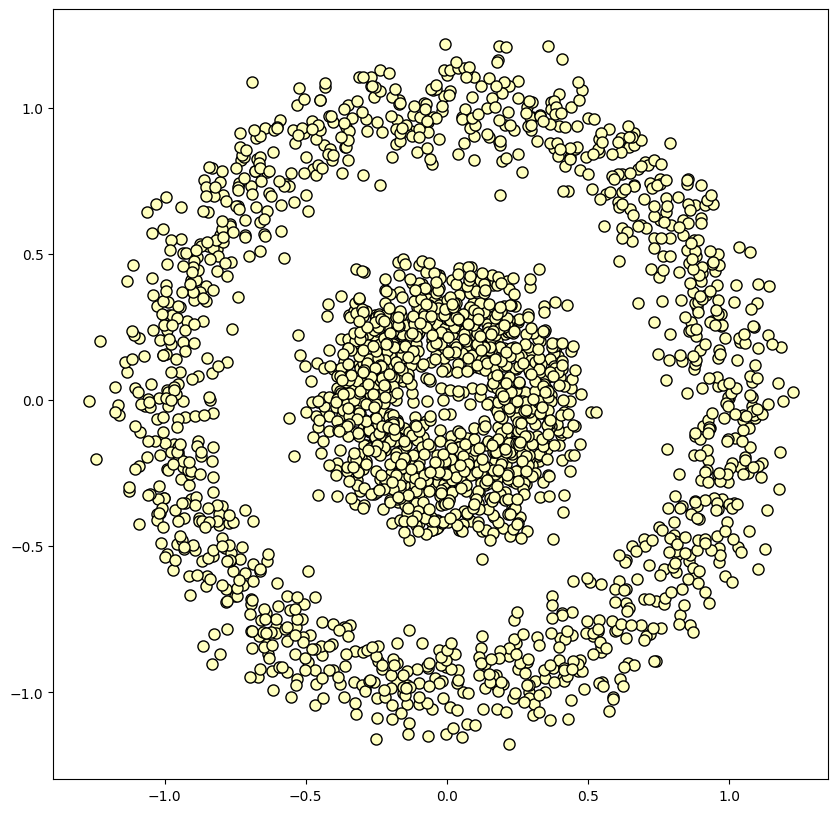

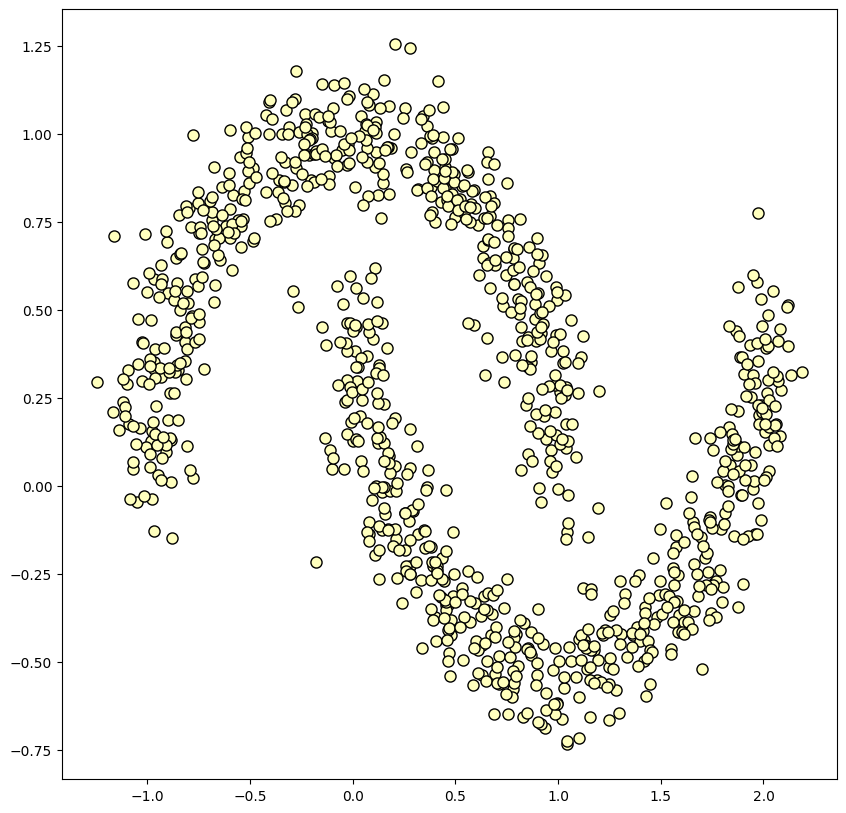

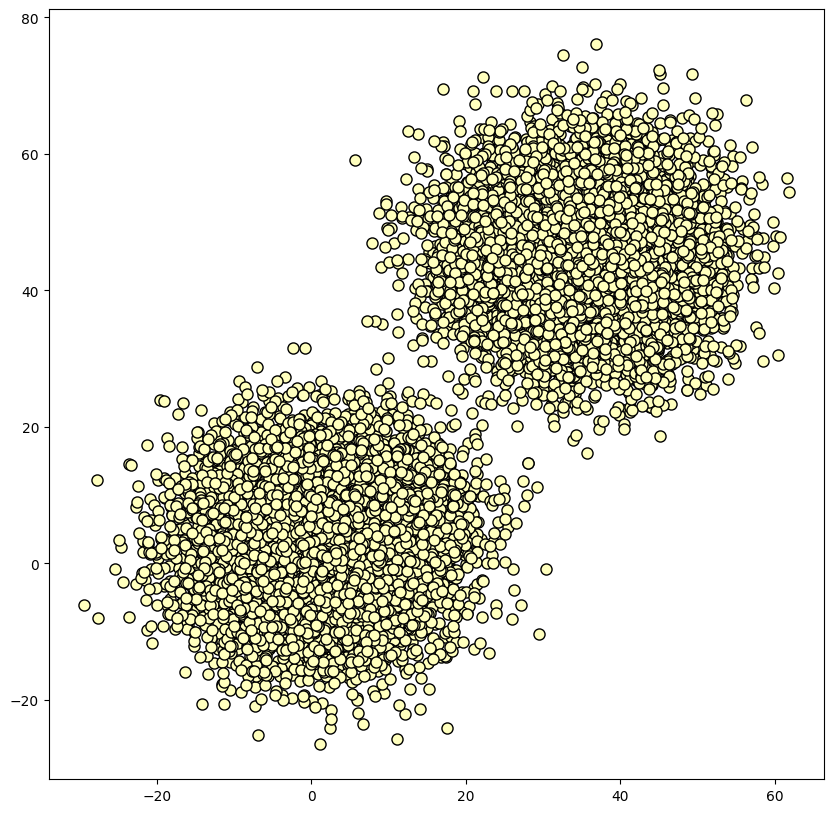

In [ ]:
plot_clustering(X_circles, np.zeros(X_circles.shape[0]))
plot_clustering(X_moons, np.zeros(X_moons.shape[0]))
plot_clustering(X_blobs, np.zeros(X_blobs.shape[0]))

In [ ]:
model_circles_kmeans = KMeans(n_clusters=2).fit(X_circles)

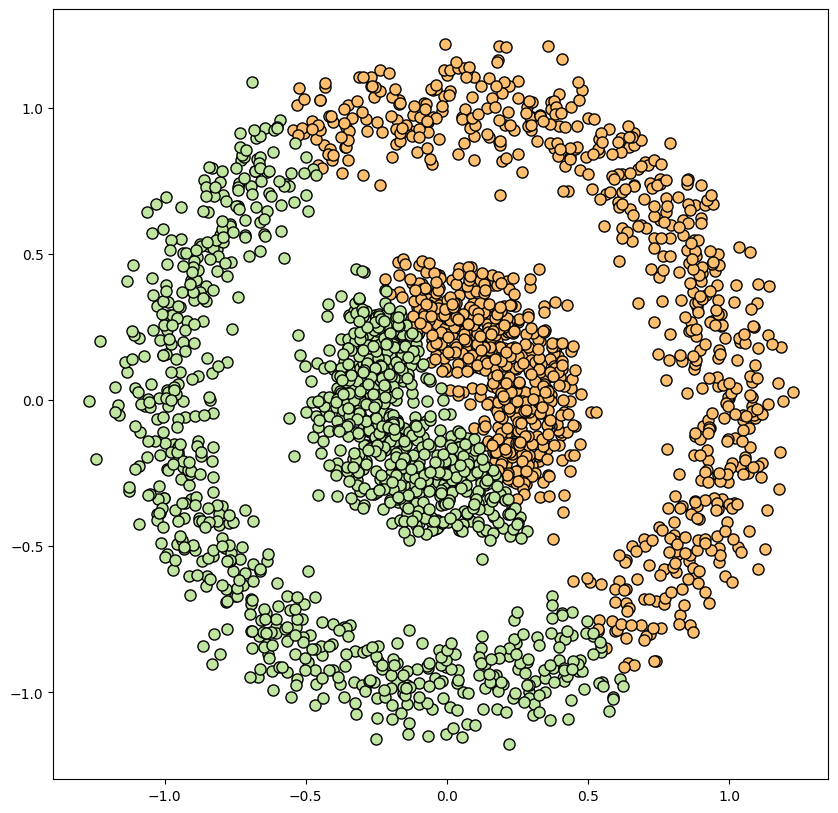

In [ ]:
plot_clustering(X_circles, model_circles_kmeans.labels_)

In [ ]:
model_circles_kmeans2 = KMeans(n_clusters=3).fit(X_blobs)

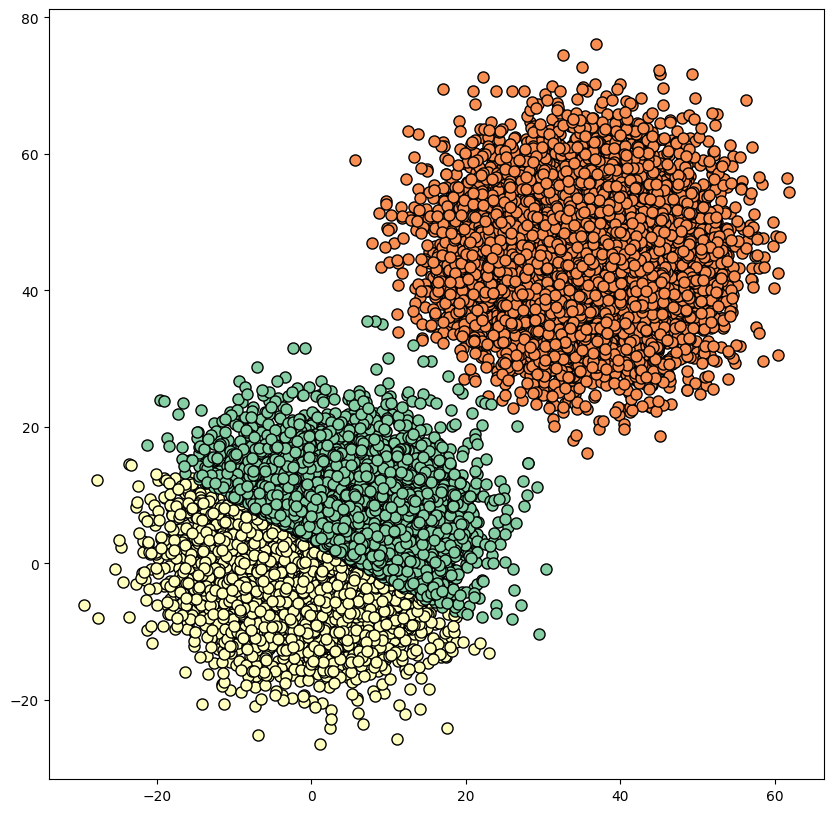

In [ ]:
plot_clustering(X_blobs, model_circles_kmeans2.labels_)

In [ ]:
# make a k-means model with k=30
model_circles = KMeans(n_clusters=30).fit(X_circles)

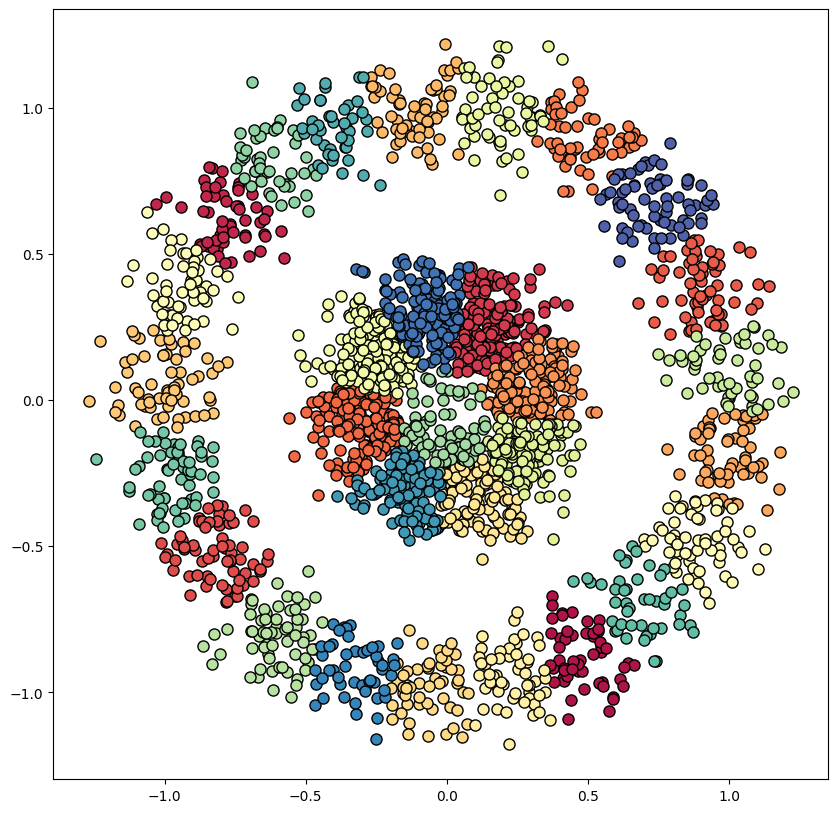

In [ ]:
# visual check of the k-means model
plot_clustering(X_circles, model_circles.labels_)

In [ ]:
# create a k-meansCD model from that k-means model
model_cd_circles = KMeansCD(model_circles, X_circles).fit()

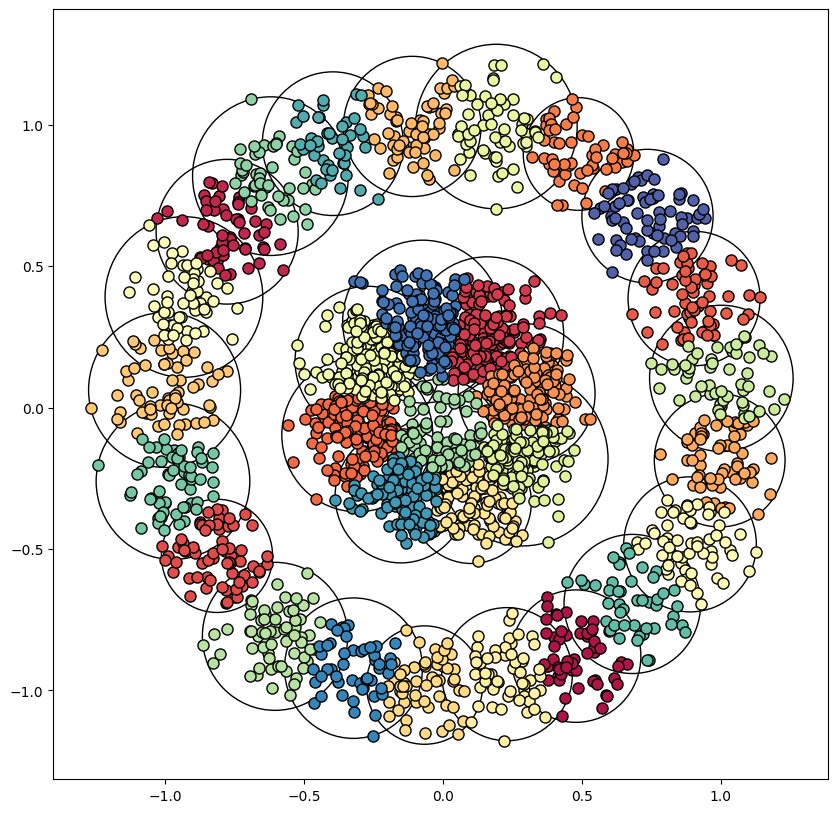

In [ ]:
# the original k-means model with the circles from k-meansCD overlayed
plot_clustering(X_circles, model_circles.labels_, model_circles.cluster_centers_, 
                             model_cd_circles.radius_matrix_)

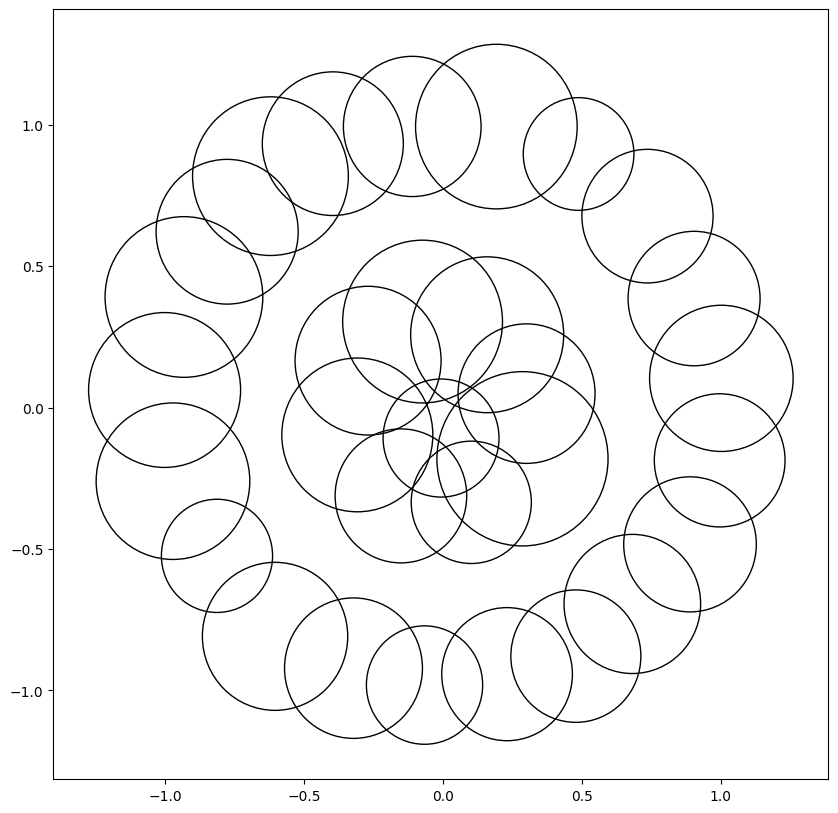

In [ ]:
# Only the circles for visibility
plot_clustering(X_circles, model_circles.labels_, model_circles.cluster_centers_, 
                             model_cd_circles.radius_matrix_, only_circles=True)

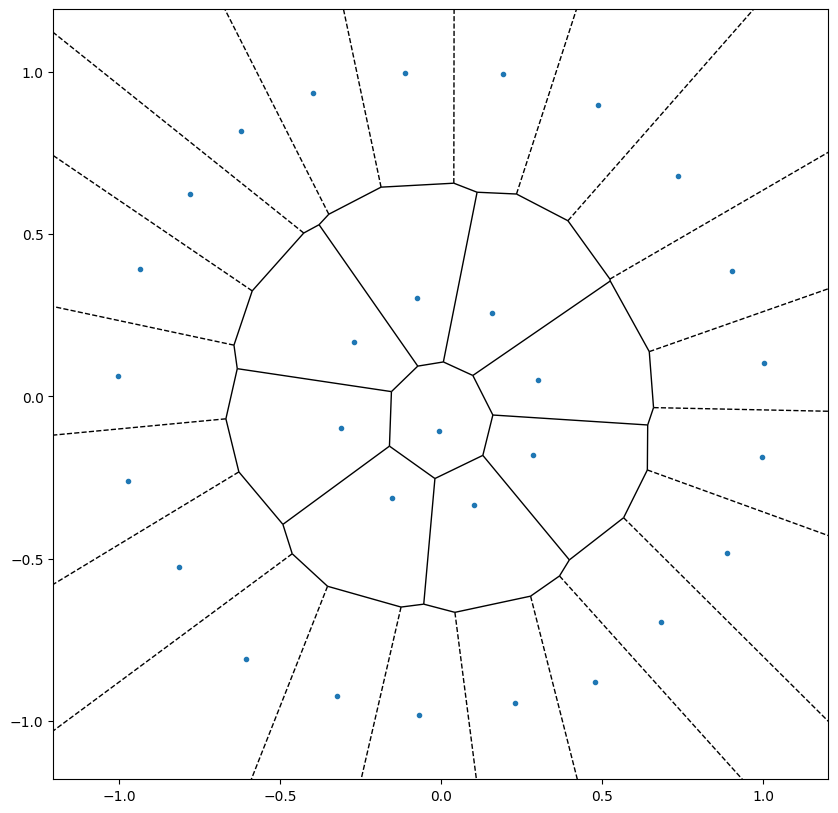

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10) 
vor = Voronoi(model_circles.cluster_centers_)
fig = voronoi_plot_2d(vor, show_vertices=False)
plt.show()

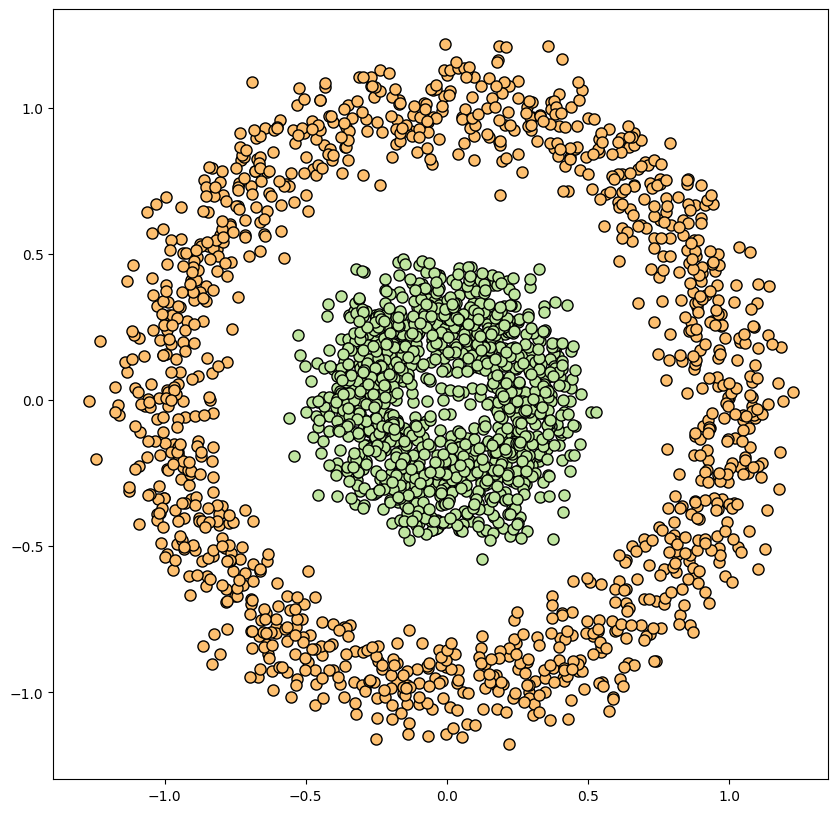

In [ ]:
# plot the k-meansCD clustering
plot_clustering(X_circles, model_cd_circles.labels_)

In [ ]:
# can be done for all toy data sets above

## 4. FCPS (Fundamental Clustering Problem Suite)  <a name="clearlyseparabledatasets"></a>

Datasets from:

M. Gagolewski and A. Cena (Eds.), Benchmark Suite for Clustering Algorithms -- Version 1, 2020, https://github.com/gagolews/clustering_benchmarks_v1.

### 4.1 FCPS Atom

In [ ]:
at_X = np.loadtxt("data/atom.data") # data
at_y = np.loadtxt("data/atom.labels0") # intended clustering

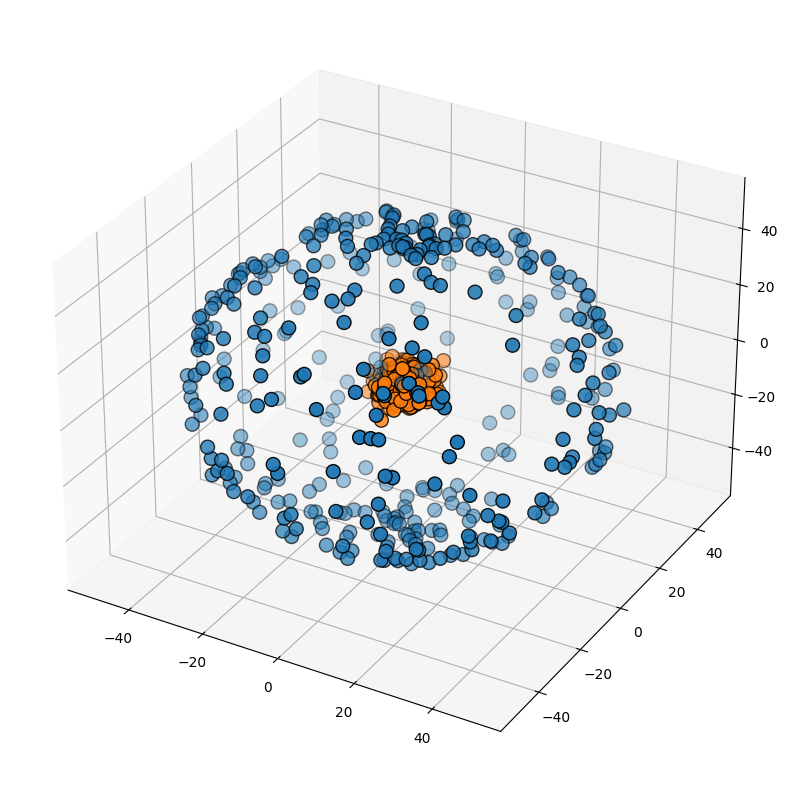

In [ ]:
# plot of intended clustering
plot_clustering_3d(at_X, at_y)

In [ ]:
atom_proportion = []
for i in range(100):
    model_atom = KMeans(n_clusters=20).fit(at_X)
    new_labels_atom = KMeansCD(model_atom, at_X).fit().labels_
    new_labels_atom_un = unify_labels(at_y, new_labels_atom)
    atom_proportion.append(sum(new_labels_atom_un == at_y)/at_y.shape[0])

In [ ]:
np.median(atom_proportion), np.subtract(*np.percentile(atom_proportion, [75, 25]))

(1.0, 0.0)

### 4.2 FCPS Chainlink

In [ ]:
cl_X = np.loadtxt("data/chainlink.data") # data
cl_y = np.loadtxt("data/chainlink.labels0") # intended clustering

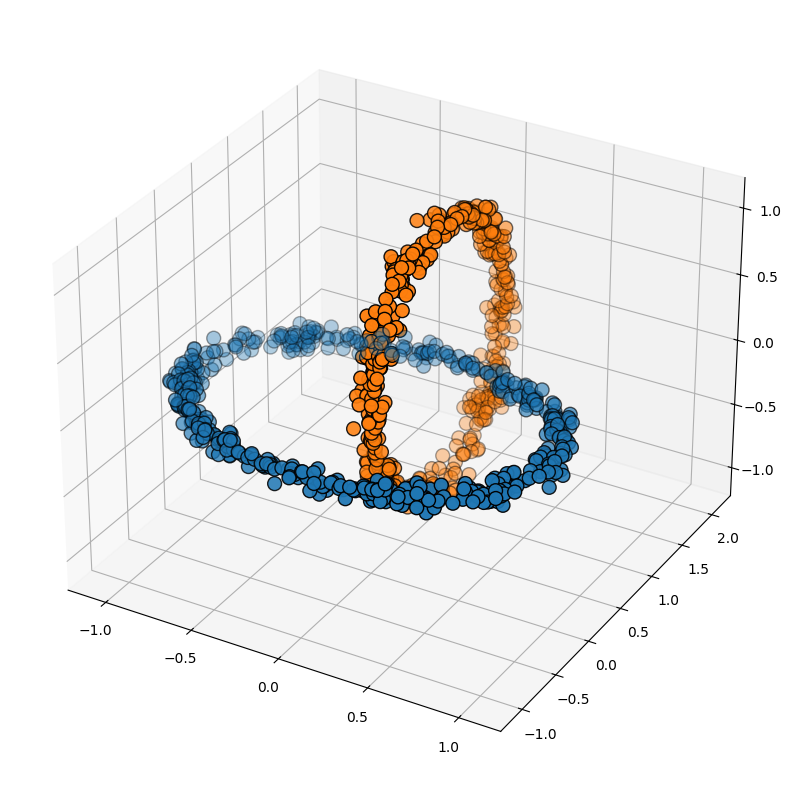

In [ ]:
plot_clustering_3d(cl_X, cl_y) # plot intended clustering

In [ ]:
X = cl_X
y= cl_y
proportion = []
for i in range(100):
    model = KMeans(n_clusters=16).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(1.0, 0.17700000000000005)

### 4.3 FCPS Hepta

In [ ]:
h_X = np.loadtxt("data/hepta.data") # data set
h_y = np.loadtxt("data/hepta.labels0") # intended clustering

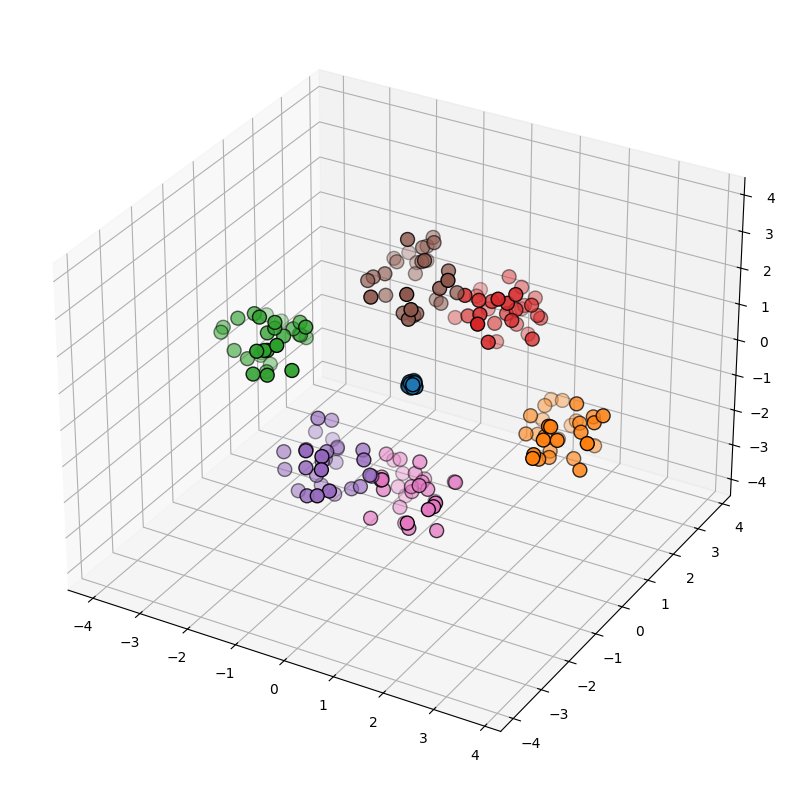

In [ ]:
plot_clustering_3d(h_X, h_y) # plot ontended clustering

In [ ]:
X = h_X
y= h_y
proportion = []
for i in range(100):
    model = KMeans(n_clusters=20).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(1.0, 0.0)

### 4.4 FCPS Lsun

In [ ]:
lsun_X = np.loadtxt("data/fcps_lsun.data") # data set
lsun_y = np.loadtxt("data/fcps_lsun.labels0") # intended clustering

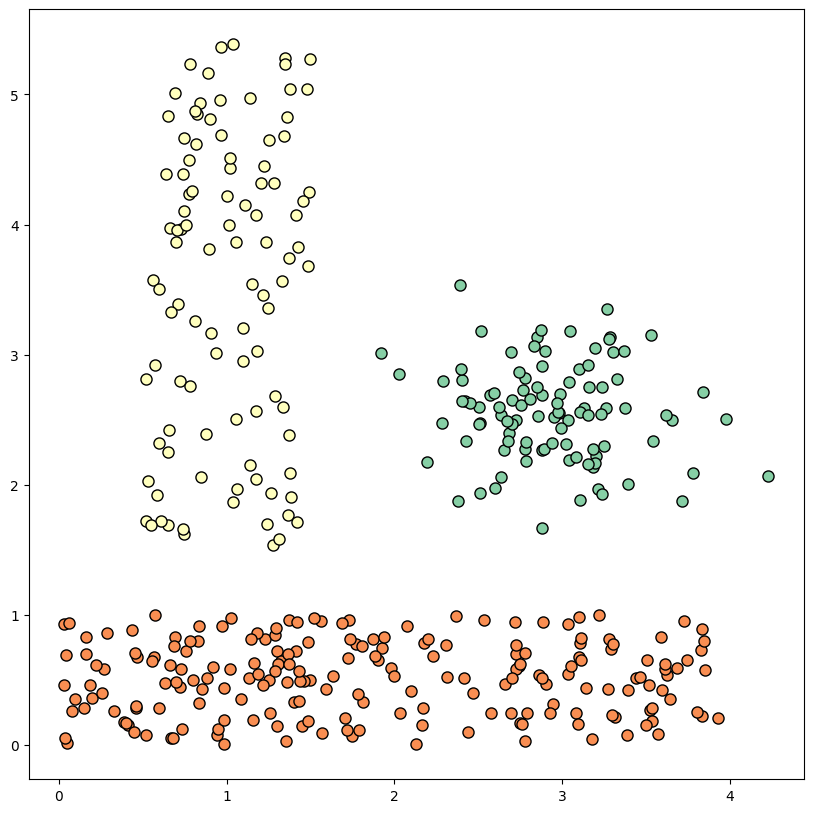

In [ ]:
plot_clustering(lsun_X, lsun_y) # plot intended clustering

In [ ]:
X = lsun_X
y= lsun_y
proportion = []
for i in range(100):
    model = KMeans(n_clusters=20).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(1.0, 0.07499999999999996)

### 4.5 FCPS Target

In [ ]:
target_X = np.loadtxt("data/fcps_target.data") # data set
target_y = np.loadtxt("data/fcps_target.labels0") # intended labels

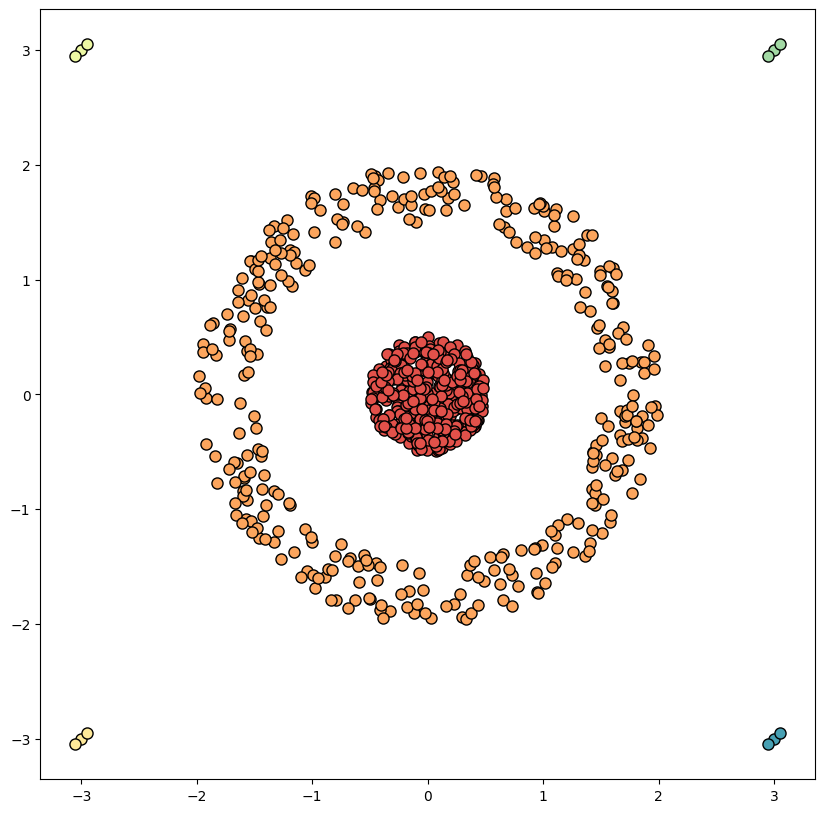

In [ ]:
plot_clustering(target_X, target_y) # plot intended clustering

In [ ]:
X = target_X
y= target_y
clusters = 17
proportion = []
for i in range(100):
    model = KMeans(n_clusters=clusters).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(0.9142857142857143, 0.21720779220779218)

### 4.6 FCPS Tetra

In [ ]:
tetra_X = np.loadtxt("data/tetra.data") # data set
tetra_y = np.loadtxt("data/tetra.labels0") # intended labels

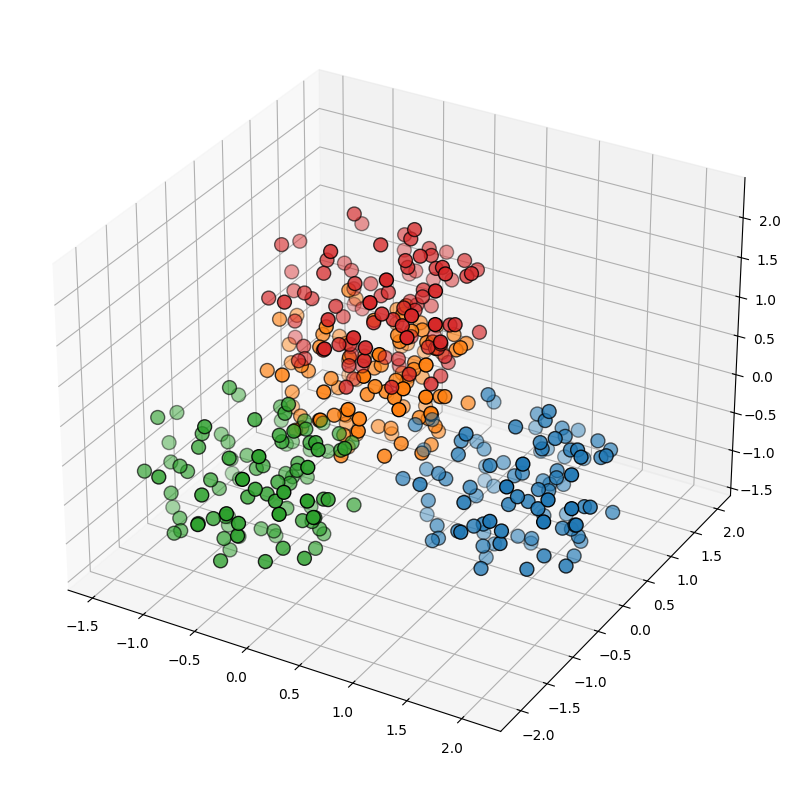

In [ ]:
plot_clustering_3d(tetra_X, tetra_y) # plot intended clustering

In [ ]:
X = tetra_X
y= tetra_y
clusters = 4
proportion = []
for i in range(100):
    model = KMeans(n_clusters=clusters).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(1.0, 0.0)

### 4.7 FCPS Twodiamonds

In [ ]:
diamonds_X = np.loadtxt("data/twodiamonds.data") # data
diamonds_y = np.loadtxt("data/fcps_twodiamonds.labels0") # intended labels

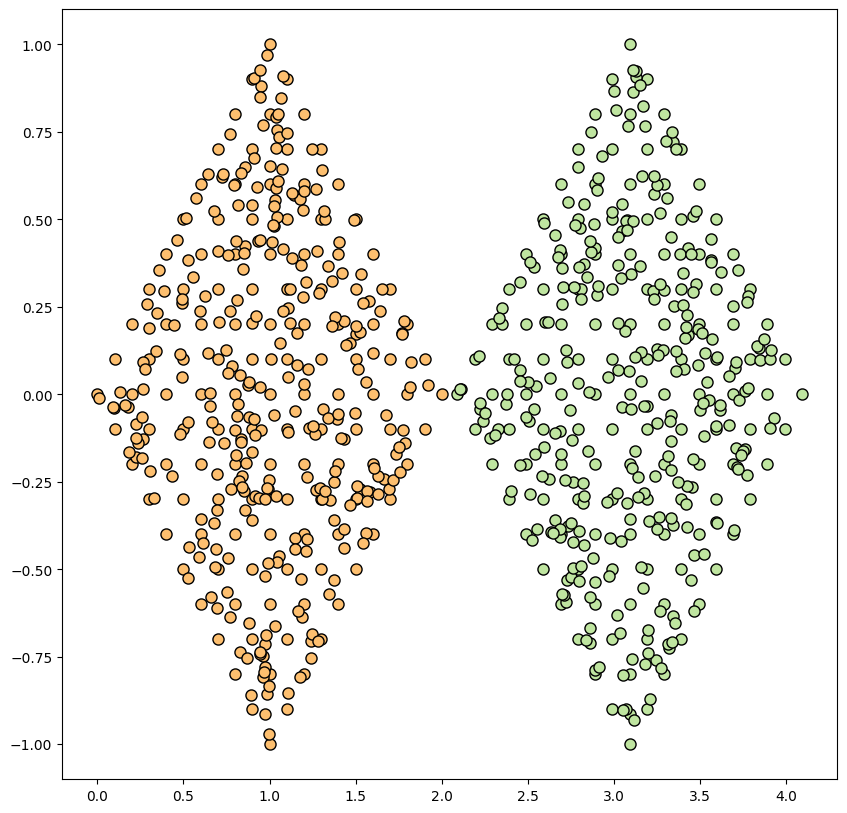

In [ ]:
plot_clustering(diamonds_X, diamonds_y) # plot intended clustering

In [ ]:
X = diamonds_X
y= diamonds_y
clusters = 10
proportion = []
for i in range(100):
    model = KMeans(n_clusters=clusters).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(1.0, 0.0)

### 4.8 FCPS Wingnut 

In [ ]:
wingnut_X = np.loadtxt("data/wingnut.data") # data
wingnut_y = np.loadtxt("data/fcps_wingnut.labels0") # intended labels

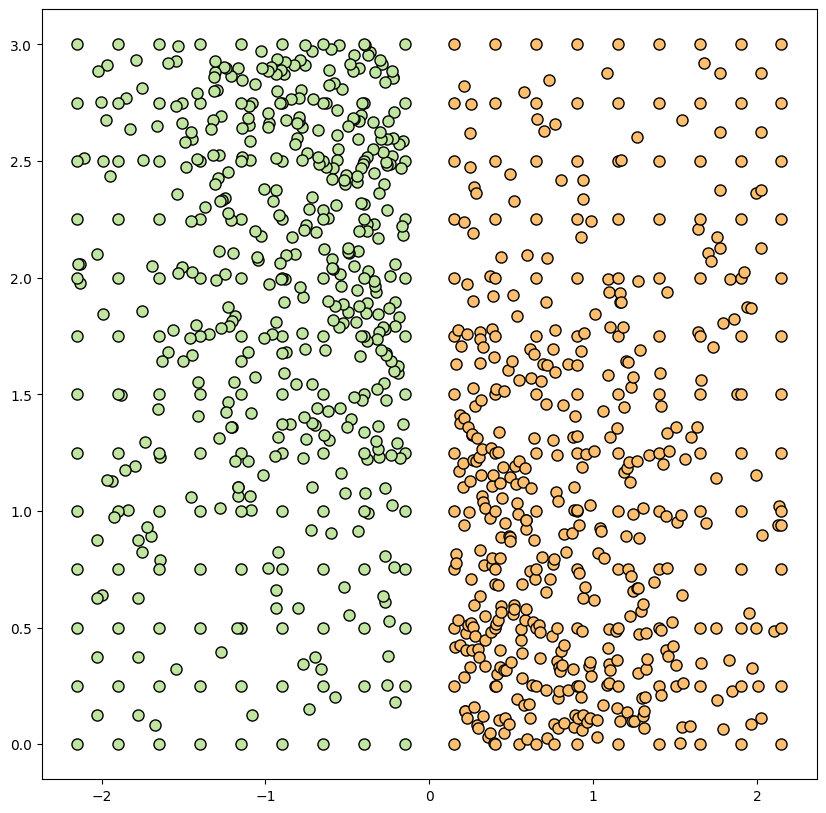

In [ ]:
plot_clustering(wingnut_X, wingnut_y) # plot indended clustering

In [ ]:
X = wingnut_X
y= wingnut_y
clusters = 70
proportion = []
for i in range(100):
    model = KMeans(n_clusters=clusters).fit(X)
    new_labels = KMeansCD(model, X).fit().labels_
    new_labels_un = unify_labels(y, new_labels)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(0.9822834645669292, 0.4869586614173229)

# 5 Test: Chameleon_t5_8k


data from M. Gagolewski and A. Cena (Eds.), Benchmark Suite for Clustering Algorithms -- Version 1, 2020, https://github.com/gagolews/clustering_benchmarks_v1, "Other"

In [ ]:
# Reworked to cope with density
class KMeansCD_den:
    
    """
    Takes a fitted k-means object and data as input. 
    Creates new clustering depending on the input parameters via the fit() method
    
    self.labels_: the new labels
    self.ppr_: points per radius. Can be used to estimate minPts for density case
    self.radius_matrix_: for debugging and understanding
    self.adjacency_matrix_: for debugging and understanding
    self.connected_subgraphs_: for debugging and understanding
    
    """
    
    def __init__(self, kmeans, data, high=100, low=0):
        self.kmeans = kmeans
        self.data = data
        self.high = high
        self.low = low
        
    def create_radius_vector(self, X, cluster_centers, labels):
        """
        Creates the radius vector
        """
        r = np.zeros((1, cluster_centers.shape[0]))
        for i in range(r.shape[1]):
            p = X[labels == i]
            c = cluster_centers[i]
            d = np.zeros((1, p.shape[0]))
            for j in range(p.shape[0]):
                d[0,j]=np.sqrt(((p[j]-c)@(p[j]-c).T))
            r[0, i]=np.max(d)
        return r

    def create_adjacency_matrix_cluster_centers_w_density(self, old_labels, cluster_centers, radii, 
                                                          low, high):
        """
        Creates the adjacency matrix for the cluster center by creating:
        * a distance matrix
        * a radius matrix
        * distance matrix
        * where this is > 0 put a 1, else a 0
        """
        dist_matrix = pairwise_distances(cluster_centers)
        radius_matrix = radii + radii.T
        adjacency_matrix = ((radius_matrix - dist_matrix) > 0)*1
        dimension = cluster_centers.shape[1]
        
        print("min_r", np.min(radii[0]), "max_r", np.max(radii[0]))
        # drop the rows for cluster centers with too little points
        
        ppr_list = np.zeros(cluster_centers.shape[0])
        
        for i in range(cluster_centers.shape[0]):
            if radii[0, i] != 0:
                ppr_list[i] = sum(old_labels == i)/(radii[0, i])**dimension         
                
        ppr_min = np.percentile(ppr_list, low) # good: 60
        ppr_max = np.percentile(ppr_list, high) # good: 99
        
        for i in range(cluster_centers.shape[0]):
            if ppr_list[i] > ppr_max or ppr_list[i] < ppr_min:
                adjacency_matrix[i,:] = 0
        return adjacency_matrix, ("minppr, meanppr, maxppr:", np.min(ppr_list), np.mean(ppr_list), np.max(ppr_list))

    def find_connected_subgraphs(self, am):
        """
        Recursively merge the array rows, if they have a 1 in common
        """
        cam=am.copy()
        for i in range(cam.shape[0]):
            for j in range(cam.shape[0]):
                if i!=j and sum(cam[i]*cam[j]) != 0:
                    cam[i]=((cam[i] + cam[j]) > 0)
        cam = (cam > 0)*1
        connected_subgraphs = np.unique(cam, axis=0)
        return connected_subgraphs

    def create_new_labels(self, old_labels, connected_subgraphs):
        cs_to_numbers = []
        labels = np.ones(old_labels.shape[0])*-1
        new_label_base = max(old_labels)+1
        for i in range(connected_subgraphs.shape[0]):
            temp_list = np.where(connected_subgraphs[i]==1)[0]
            cs_to_numbers.append(temp_list)
        for i in range(connected_subgraphs.shape[0]):
            for j in cs_to_numbers[i]:
                labels[np.where(old_labels==j)]=new_label_base+i
        return labels
        
    def fit(self):
        self.radius_matrix_ = self.create_radius_vector(self.data, self.kmeans.cluster_centers_, self.kmeans.labels_)
        self.adjacency_matrix_, self.ppr_ = self.create_adjacency_matrix_cluster_centers_w_density(
                                                                                   self.kmeans.labels_, 
                                                                                   self.kmeans.cluster_centers_, 
                                                                                   self.radius_matrix_, 
                                                                                   high = self.high,
                                                                                   low = self.low)
        self.connected_subgraphs_ = self.find_connected_subgraphs(self.adjacency_matrix_)
        self.labels_ = self.create_new_labels(self.kmeans.labels_, self.connected_subgraphs_)
        return self

In [ ]:
chameleon_t5_8k_X = np.loadtxt("data/chameleon_t5_8k.data") # data
chameleon_t5_8k_y = np.loadtxt("data/chameleon_t5_8k.labels0") # intended labels

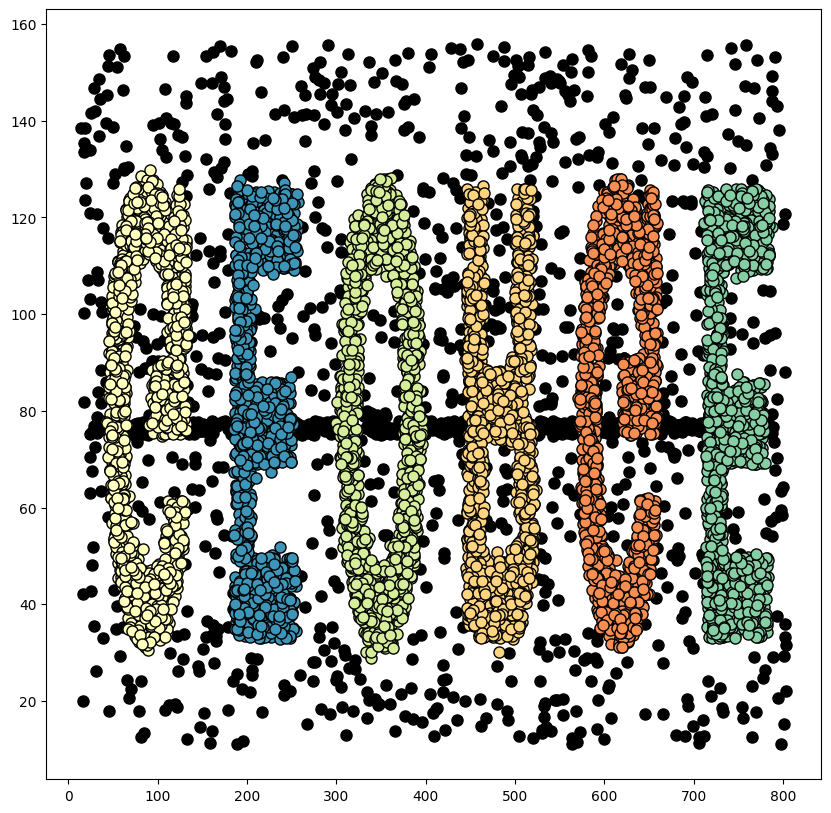

In [ ]:
plot_clustering(chameleon_t5_8k_X, chameleon_t5_8k_y, outliers=0) # plot intended clustering

In [ ]:
# create k-means model
model_chameleon_t5_8k = KMeans(n_clusters=300).fit(chameleon_t5_8k_X)

In [ ]:
## create k-means with cluster merging and density model
idisj = KMeansCD_den(model_chameleon_t5_8k, chameleon_t5_8k_X, low=60, high=99).fit()
new_labels_chameleon_t5_8k = idisj.labels_

min_r 5.062503164293648 max_r 24.213459020061144


In [ ]:
# unify labels
new_labels_chameleon_t5_8k_un = unify_labels(chameleon_t5_8k_y, new_labels_chameleon_t5_8k, labels1_outlier=0)

In [ ]:
# 1.0 means 100% identical
sum(new_labels_chameleon_t5_8k_un == chameleon_t5_8k_y)/chameleon_t5_8k_y.shape[0]

0.9215

In [ ]:
idisj.ppr_

('minppr, meanppr, maxppr:',
 0.013415133659718192,
 0.29325129597461763,
 0.9650251192097775)

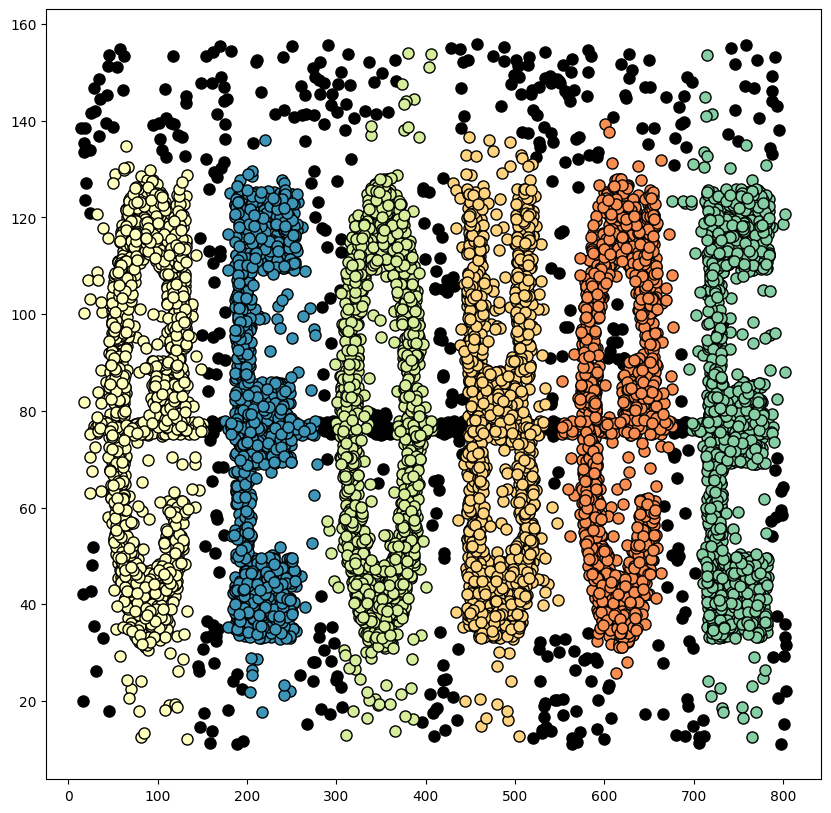

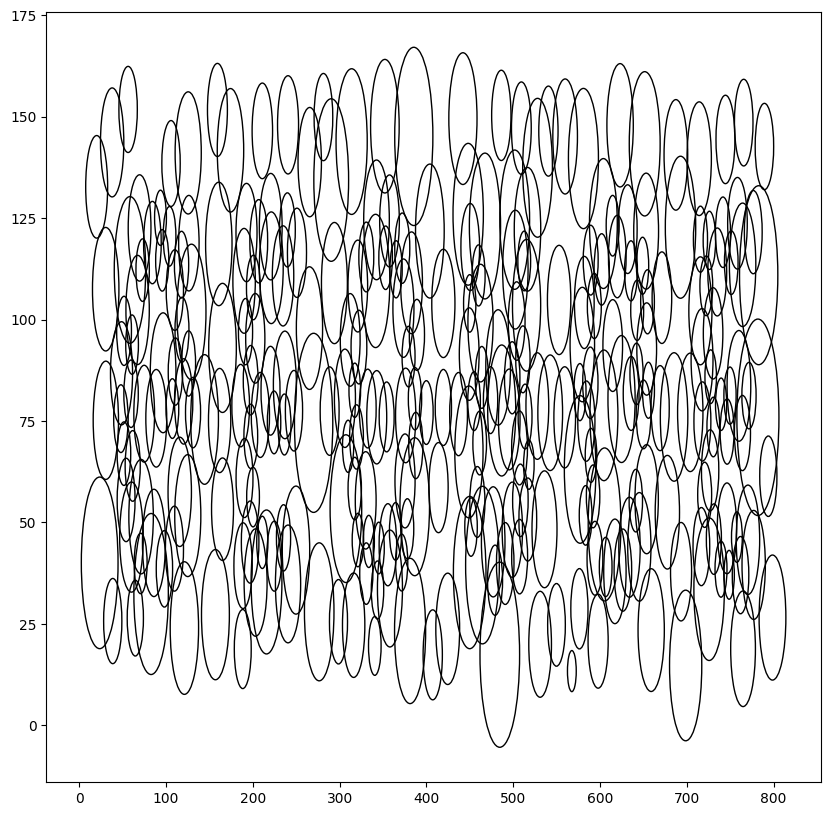

In [ ]:
# plot clustering
plot_clustering(chameleon_t5_8k_X, new_labels_chameleon_t5_8k_un, outliers=0)
plot_clustering(chameleon_t5_8k_X, new_labels_chameleon_t5_8k_un, model_chameleon_t5_8k.cluster_centers_, idisj.radius_matrix_, only_circles=True, outliers=0)

# 6 Splitting the Dataset: Toy Examples <a name="six"></a>

In [ ]:
X_circles_1 = X_circles[np.where(X_circles[:, 0] >0)]
X_circles_2 = X_circles[np.where(X_circles[:, 0] <= 0)]

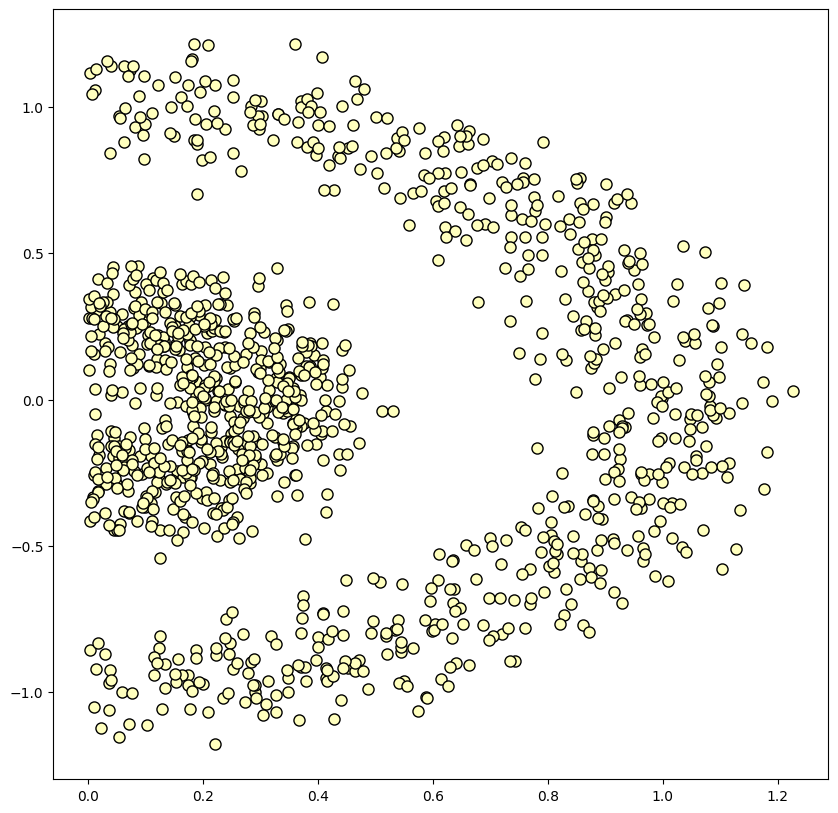

In [ ]:
plot_clustering(X_circles_1, np.zeros(X_circles_1.shape[0]))

In [ ]:
model_circles_1 = KMeans(n_clusters=15).fit(X_circles_1)

In [ ]:
model_cd_circles_1 = KMeansCD(model_circles_1, X_circles_1).fit()

min_r 0.15537952407461722 max_r 0.2971013590917187


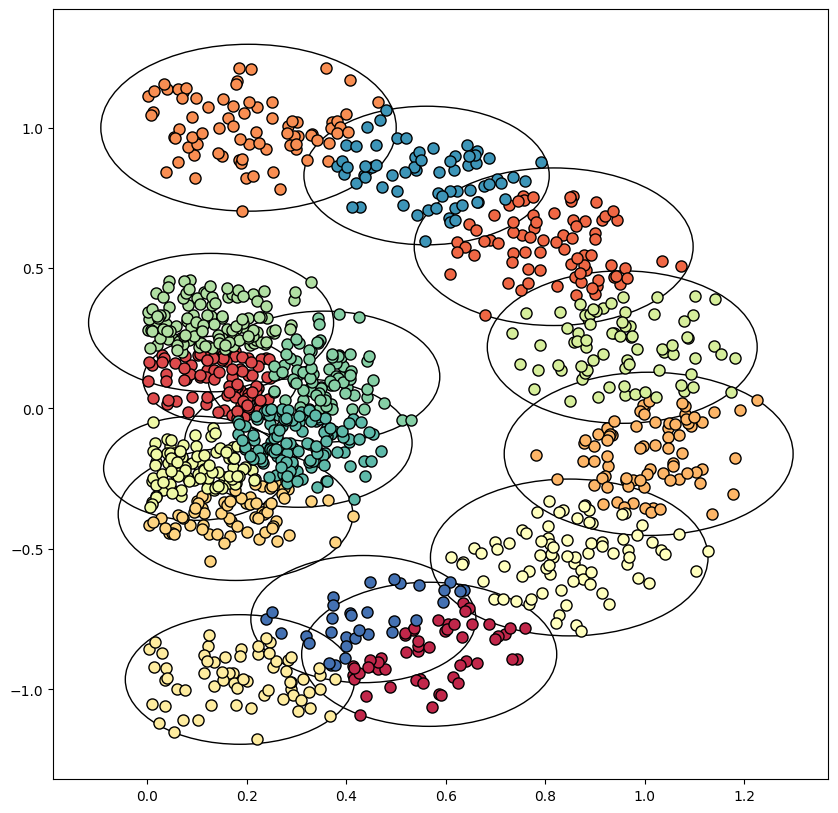

In [ ]:
plot_clustering(X_circles_1, model_circles_1.labels_, model_circles_1.cluster_centers_, 
                             model_cd_circles_1.radius_matrix_)

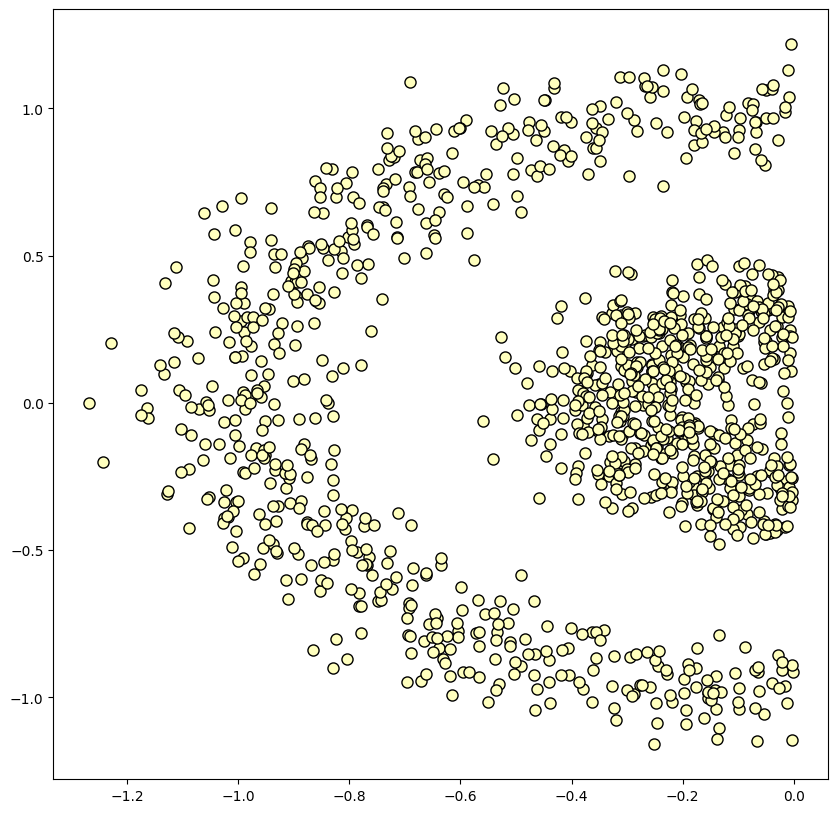

In [ ]:
plot_clustering(X_circles_2, np.zeros(X_circles_2.shape[0]))

In [ ]:
model_circles_2 = KMeans(n_clusters=15).fit(X_circles_2)

In [ ]:
model_cd_circles_2 = KMeansCD(model_circles_2, X_circles_2).fit()

min_r 0.2134945120226401 max_r 0.29371892942593697


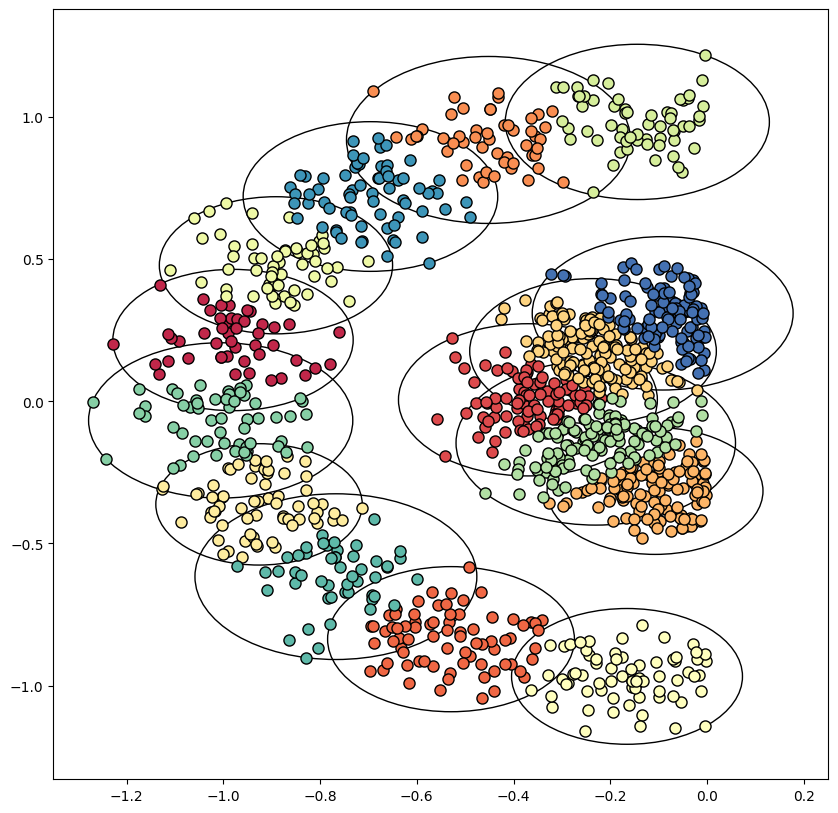

In [ ]:
plot_clustering(X_circles_2, model_circles_2.labels_, model_circles_2.cluster_centers_, 
                             model_cd_circles_2.radius_matrix_)

In [ ]:
model_full_labels = model_circles_2.labels_

In [ ]:
temp = model_circles_2.labels_+15
full_labels = np.concatenate((model_circles_1.labels_, temp), axis=0)
full_cluster_centers = np.concatenate((model_circles_1.cluster_centers_, model_circles_2.cluster_centers_), axis=0)
full_radius_matrix = np.concatenate((model_cd_circles_1.radius_matrix_, model_cd_circles_2.radius_matrix_), axis=1)
full_data = np.concatenate((X_circles_1, X_circles_2))

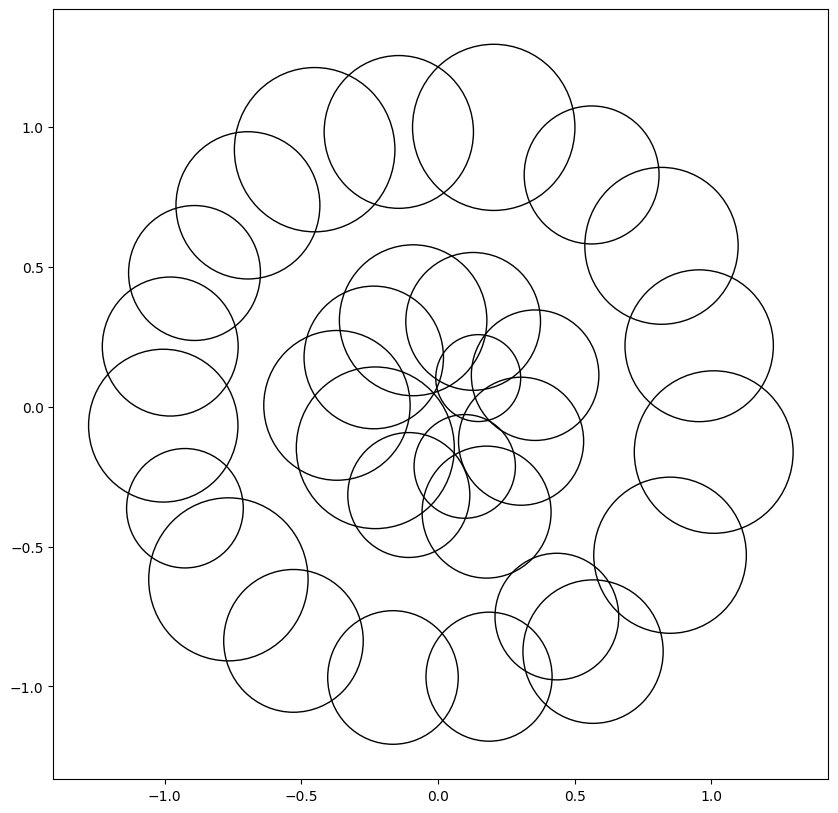

In [ ]:
plot_clustering(full_data, full_labels, full_cluster_centers, 
                             full_radius_matrix, only_circles=True)

# 7 Splitting the dataset: FCPS <a name="seven"></a>

## 7.1 Chose one of below datasets, then run the test further down

In [ ]:
X = X_circles
y = y_circles
k = 30
minPts=-1

In [ ]:
at_X = np.loadtxt("data/atom.data") # data
at_y = np.loadtxt("data/atom.labels0") # intended clustering
X = at_X
y = at_y
k = 30

In [ ]:
cl_X = np.loadtxt("data/chainlink.data") # data
cl_y = np.loadtxt("data/chainlink.labels0") # intended clustering
X = cl_X
y = cl_y

In [ ]:
h_X = np.loadtxt("data/hepta.data") # data set
h_y = np.loadtxt("data/hepta.labels0") # intended clustering
X = h_X
y = h_y

In [ ]:
# plot differently, adjust y-axis
lsun_X = np.loadtxt("data/fcps_lsun.data") # data set
lsun_y = np.loadtxt("data/fcps_lsun.labels0") # intended clustering
X = lsun_X
y = lsun_y
k = 27

In [ ]:
target_X = np.loadtxt("data/fcps_target.data") # data set
target_y = np.loadtxt("data/fcps_target.labels0") # intended labels
X = target_X
y = target_y
k = 16

In [ ]:
# does not work
tetra_X = np.loadtxt("data/tetra.data") # data set
tetra_y = np.loadtxt("data/tetra.labels0") # intended labels
X = tetra_X
y = tetra_y
k = 40

In [ ]:
#plot differently, adjust y-axis
diamonds_X = np.loadtxt("data/twodiamonds.data") # data
diamonds_y = np.loadtxt("data/fcps_twodiamonds.labels0") # intended labels
X = diamonds_X
y = diamonds_y
k = 10

In [ ]:
wingnut_X = np.loadtxt("data/wingnut.data") # data
wingnut_y = np.loadtxt("data/fcps_wingnut.labels0") # intended labels
X = wingnut_X
y = wingnut_y
k = 90

## 7.2 Cut and Reassemble experiment

In [ ]:
# on the x and y axis, cut through the middle
x_cut = 1/2 * (min(X[:,0]) + max(X[:,0]))
y_cut = 1/2 * (min(X[:,1]) + max(X[:,1]))
print(x_cut, y_cut)

0.0 1.5


min_r 0.20287681123750737 max_r 0.41966387016698975
min_r 0.1319282190469182 max_r 0.3250117453547061
min_r 0.12818394592616375 max_r 0.2642599271800016
min_r 0.2548138826462954 max_r 0.3807260805630457


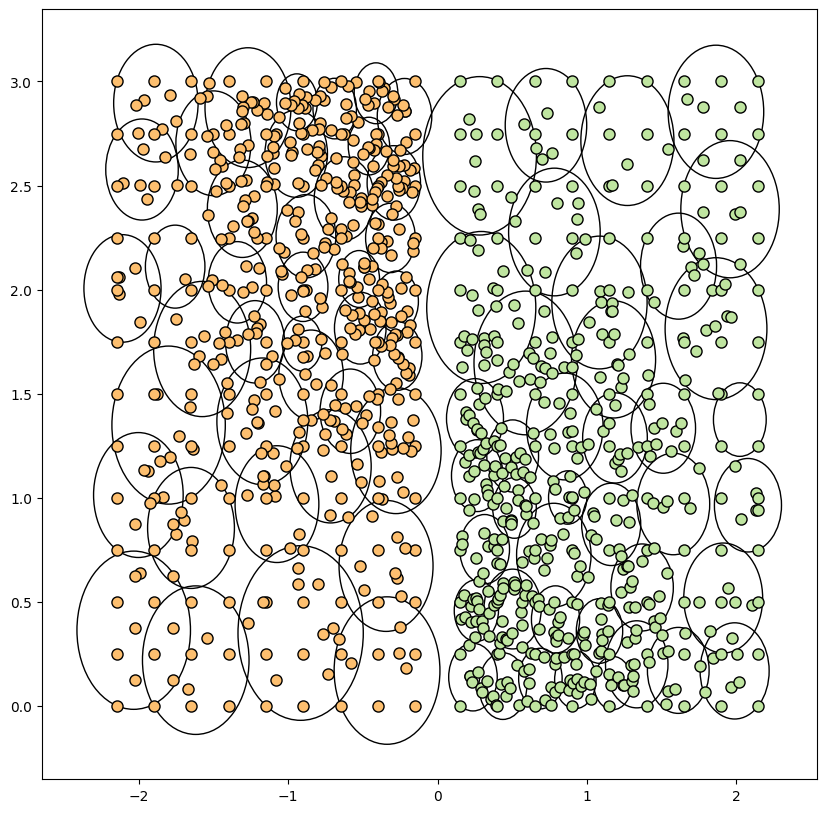

min_r 0.23452787853138587 max_r 0.36032373124042555
min_r 0.12407462678143272 max_r 0.29457587195488294
min_r 0.12828794054195608 max_r 0.256674646116886
min_r 0.2310861078955143 max_r 0.46800966331033494


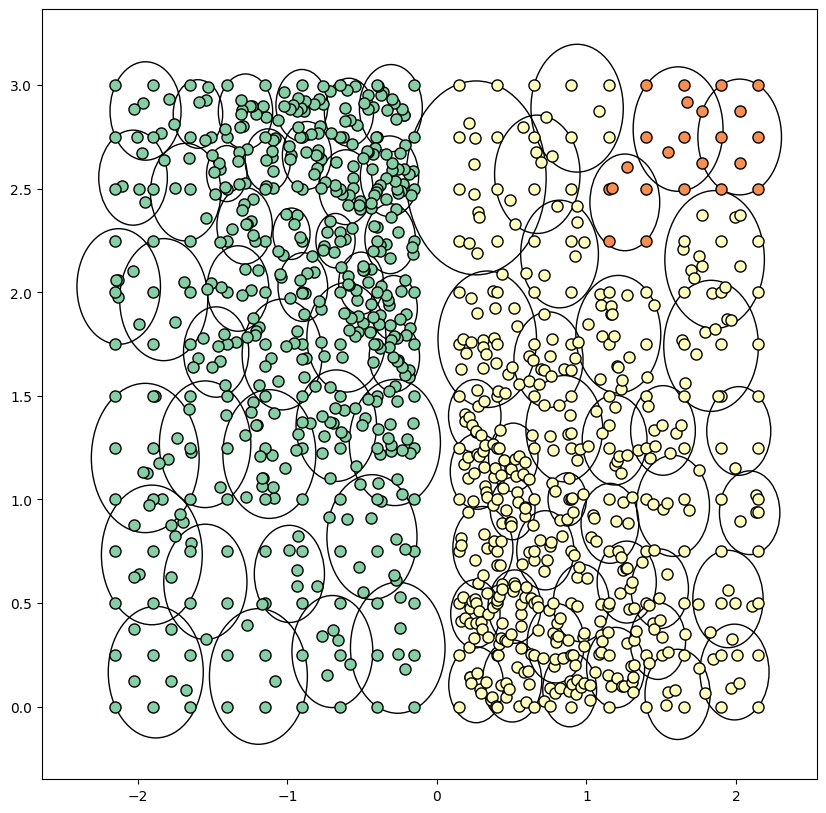

min_r 0.20150866933074182 max_r 0.43891153097815383
min_r 0.12828794685448192 max_r 0.2552124018537316
min_r 0.14753082771535433 max_r 0.2709436227595641
min_r 0.2344590405633136 max_r 0.37345274644679377


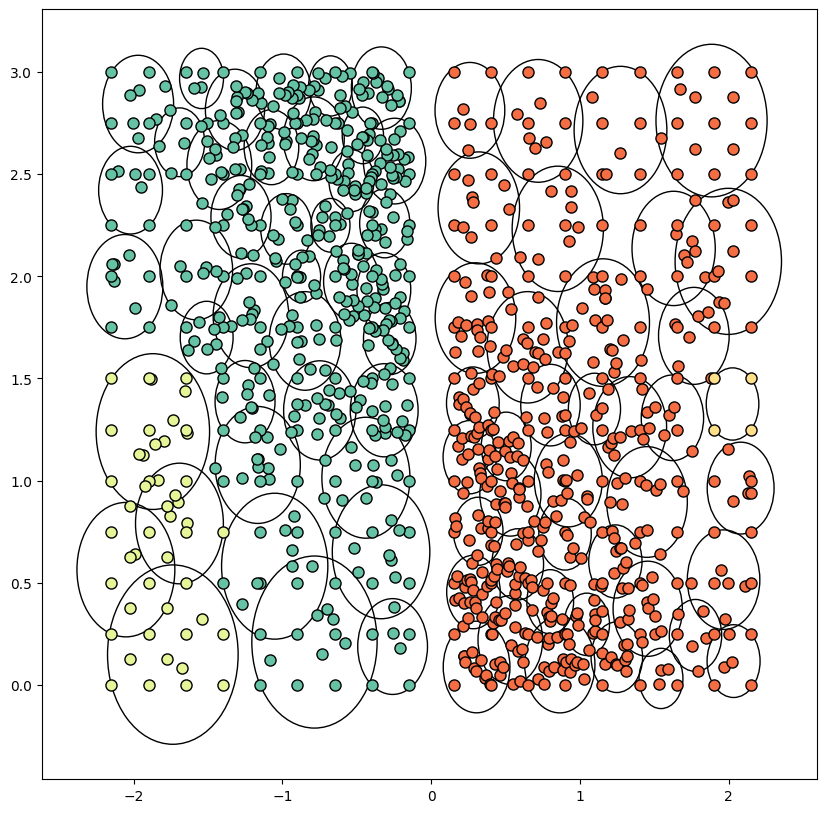

In [ ]:
### set correct percentage for k, and repetition for the experiment
k_perct = 0.08 # 8%
repet = 3 # 3 rounds. For high rounds comment the last line to not print 100 images
###
success = []
for i in range(repet):
    X1 = X[np.where((X[:, 0] <= x_cut) & (X[:, 1] <= y_cut))]
    X2 = X[np.where((X[:, 0] <= x_cut) & (X[:, 1] > y_cut))]
    X3 = X[np.where((X[:, 0] > x_cut) & (X[:, 1] <= y_cut))]
    X4 = X[np.where((X[:, 0] > x_cut) & (X[:, 1] > y_cut))]
    X_data = [X1, X2, X3, X4]
    
    k1=int(k_perct*len(X1)) 
    k2=int(k_perct*len(X2))
    k3=int(k_perct*len(X3)) 
    k4=int(k_perct*len(X4)) 
    k_values = [k1, k2, k3, k4]
    #print(k_values)
    
    model_cd_labels = {}
    model = {}
    for j in range(4):
        k_value = k_values[j]
        X_value = X_data[j]
        model[j] = KMeans(n_clusters=k_value).fit(X_value)
        model_cd_labels[j] = KMeansCD(model[j], X_value).fit()

    for i in range(4):
        for j in set(model_cd_labels[i].labels_):
            if j != -1:
                model_cd_labels[i].labels_[np.where(model_cd_labels[i].labels_ == j)] = j+i*1000    
    border_cluster_centers = {}
    border_cluster_centers["left"] = []
    border_cluster_centers["right"] = []
    border_cluster_centers["top"] = []
    border_cluster_centers["bottom"] = []
    for i in range(4):
        for j in range(len(model[i].cluster_centers_)):
            if (model[i].cluster_centers_[j][0] < x_cut and \
                model[i].cluster_centers_[j][0]+model_cd_labels[i].radius_matrix_[0][j] > x_cut):
                border_cluster_centers["left"].append((model[i].cluster_centers_[j], i, j, 
                                        model_cd_labels[i].labels_[np.where(model[i].labels_ == j)][0]))
            if (model[i].cluster_centers_[j][0] > x_cut and \
                model[i].cluster_centers_[j][0]-model_cd_labels[i].radius_matrix_[0][j] < x_cut):
                border_cluster_centers["right"].append((model[i].cluster_centers_[j], i, j,
                                        model_cd_labels[i].labels_[np.where(model[i].labels_ == j)][0]))
            if (model[i].cluster_centers_[j][1] < y_cut and \
                model[i].cluster_centers_[j][1]+model_cd_labels[i].radius_matrix_[0][j] > y_cut):
                border_cluster_centers["bottom"].append((model[i].cluster_centers_[j], i, j,
                                        model_cd_labels[i].labels_[np.where(model[i].labels_ == j)][0]))
            if (model[i].cluster_centers_[j][1] > y_cut and \
                model[i].cluster_centers_[j][1]-model_cd_labels[i].radius_matrix_[0][j] < y_cut):
                border_cluster_centers["top"].append((model[i].cluster_centers_[j], i, j,
                                        model_cd_labels[i].labels_[np.where(model[i].labels_ == j)][0]))

        
    full_labels = np.concatenate((model_cd_labels[0].labels_, 
                                  model_cd_labels[1].labels_,
                                  model_cd_labels[2].labels_,
                                  model_cd_labels[3].labels_,), axis=0)
    #print(set(full_labels))
    #################################################################################################
    to_be_merged = []
    for entry in border_cluster_centers["left"]:
        for entry2 in border_cluster_centers["right"]:
            if entry[3] != -1 and entry2[3] != -1: 
                if math.dist(entry[0], entry2[0]) < model_cd_labels[entry[1]].radius_matrix_[0][entry[2]]+\
                                                model_cd_labels[entry2[1]].radius_matrix_[0][entry2[2]]:
                    to_be_merged.append([entry[3], entry2[3]])
    
    for entry in border_cluster_centers["top"]:
        for entry2 in border_cluster_centers["bottom"]:
            if entry[3] != -1 and entry2[3] != -1:
                if math.dist(entry[0], entry2[0]) < model_cd_labels[entry[1]].radius_matrix_[0][entry[2]]+\
                                                model_cd_labels[entry2[1]].radius_matrix_[0][entry2[2]]:
                    to_be_merged.append([entry[3], entry2[3]])
    for lst in to_be_merged:
        lst.sort()
    b_set = set(tuple(x) for x in to_be_merged)
    to_be_merged = [ list(x) for x in b_set ]
    to_be_merged.sort()
    #################################################################################################
    full_clustercenters = np.concatenate((model[0].cluster_centers_, 
                                                                 model[1].cluster_centers_,
                                                                 model[2].cluster_centers_,
                                                                 model[3].cluster_centers_), axis=0)
    full_radii =  np.concatenate((model_cd_labels[0].radius_matrix_, 
                                  model_cd_labels[1].radius_matrix_,
                                  model_cd_labels[2].radius_matrix_,
                                  model_cd_labels[3].radius_matrix_,), axis=1)
    full_data = np.concatenate((X_data))
    
    ################################################################################################
    already = {}
    for i in to_be_merged:
        if i[0] in already.keys() and i[1] in already.keys():
            a = already[i[0]]
            b = already[i[1]]
            full_labels[np.where(full_labels == a)] = b
            already[b] = a
        elif i[0] in already.keys():
            a = already[i[0]]
            full_labels[np.where(full_labels == a)] = i[1]
            already[a] = i[1]
        elif i[1] in already.keys():
            a = already[i[1]]
            full_labels[np.where(full_labels == a)] = i[0]
            already[a] = i[0]
        else:
            full_labels[np.where(full_labels == i[1])] = i[0]
            already[i[1]] = i[0]                        
    
    mapping = []
    for i in X_data[0]:
        mapping.append(np.where(X == i[0]))
    for i in X_data[1]:
        mapping.append(np.where(X == i[0]))
    for i in X_data[2]:
        mapping.append(np.where(X == i[0]))
    for i in X_data[3]:
        mapping.append(np.where(X == i[0]))
    labels_old_order = np.zeros_like(full_labels)
    counter = 0
    for i in full_labels:
        labels_old_order[mapping[counter][0]] = i
        counter +=1    
    new_labels_tetra_un = unify_labels(y, labels_old_order)
    success.append(sum(new_labels_tetra_un == y)/len(y))
    
    # merge all in mergelist x that are in range, and all for y. Done
    plot_clustering(full_data, full_labels, full_clustercenters, full_radii)


In [ ]:
np.median(success), np.subtract(*np.percentile(success, [75, 25]))

(0.9753937007874016, 0.03149606299212604)

# 8. K-Means standalone <a name="eight"></a>

Use data sources from above

In [ ]:
proportion = []
for i in range(100):
    model = KMeans(n_clusters=2).fit(X)
    new_labels_un = unify_labels(y, model.labels_)
    proportion.append(sum(new_labels_un == y)/y.shape[0])

In [ ]:
np.median(proportion), np.subtract(*np.percentile(proportion, [75, 25]))

(0.9635826771653543, 0.0)